In [46]:
import pandas as pd
import pandahouse as ph
import seaborn as sns

from scipy import stats
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

connection = {'host': '',
                      'database':'',
                      'user':'', 
                      'password':''
                     }

In [53]:
# сгружаем наши данные за нужный период:

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-06-06' and '2022-06-12'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

In [54]:
df = ph.read_clickhouse(q, connection=connection)

In [55]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


In [56]:
# кол-во юзеров в группах ~ одинаково:

df.exp_group.value_counts()

3    8569
2    8480
Name: exp_group, dtype: int64

In [57]:
sns.set(rc={'figure.figsize':(12,10)},
       style = 'whitegrid',
       font_scale = 1.3)

<AxesSubplot:xlabel='ctr', ylabel='Count'>

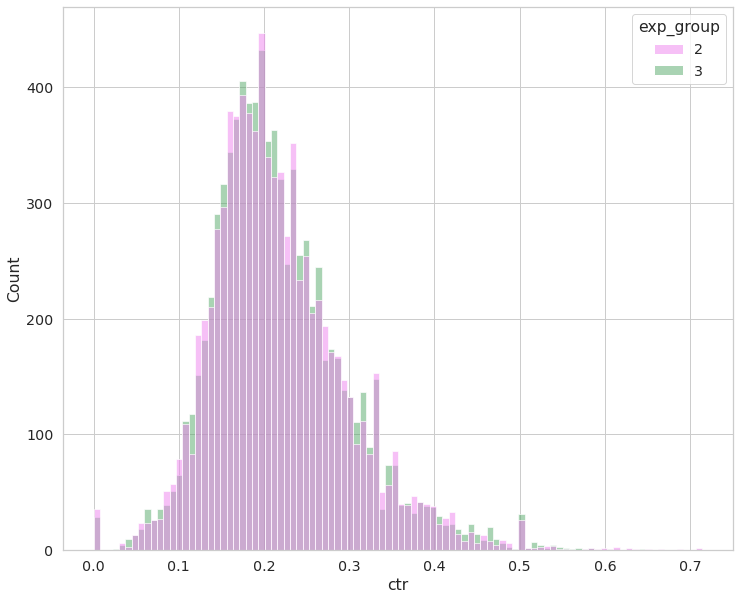

In [58]:
# строим распределения ctr для двух групп, видим, что они ~ одинаковы:

sns.histplot(data = df,
            x = 'ctr',
            hue = 'exp_group',
            palette = ['violet','g'],
            kde = False,
            alpha = 0.5)

In [59]:
# построим гистограммму распределения p-values, получившихся в результате 10000 АА-тестов на подвыборках из 500 юзеров из каждой выборки

p_value_list = []

for i in tqdm(range(10000)):
    sample2 = df[df.exp_group == 2].ctr.sample(500, replace=False)
    sample3 = df[df.exp_group == 3].ctr.sample(500, replace=False)
    p_value_list.append(stats.ttest_ind(sample2, sample3, equal_var=False)[1])
    
# p_value_list

100%|██████████| 10000/10000 [00:37<00:00, 264.01it/s]


<AxesSubplot:ylabel='Count'>

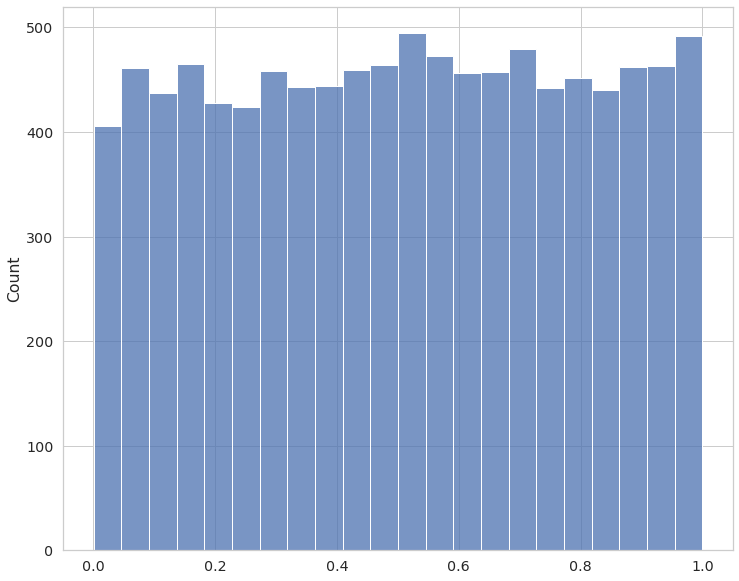

In [60]:
sns.histplot(p_value_list)

In [61]:
print(f'{len([i for i in p_value_list if i <= 0.05])/ len(p_value_list) * 100}% значений p-value меньше, либо равны 0.05')

4.47% значений p-value меньше, либо равны 0.05


Итого получаем, что FPR (False Positive Rate) менее 5% - только приблизительно в 5% случаев у нас получаются статистические значимые различия между 2 и 3 группой (в остальных 95% стат значимых различий между группами нет), а значит при принятом пороге alpha = 0.05 можно говорить о том, что система сплитования работает корректно. 